To begin to explore our tractography model, we first have to load the fibergroup.  There are several different file standards for storing tractography including .tck, .trk and .fg.  Despite their differences, they are alike in that they are composed of some finite number of streamlines.   

In [1]:
import nibabel as nib
import numpy as np

# load the tractography file into the streamsObjIN variable
streamsObjIN=nib.streamlines.load('/Users/plab/Downloads/5c5d35e2f5d2a10052842847/track.tck')

# determine the number of streamlines
print(list(np.shape(streamsObjIN.tractogram.streamlines)))


[600000]


DISCUSS NUMBER OF STREAMLINES AND RELEVANCE TO REPRESENTING THE WHITE MATTER.  NOTE DIFFERENCE BETWEEN THIS APPROACH AND 

In [2]:
#index into the tractography object and extract the first streamline
firstStreamline=streamsObjIN.tractogram.streamlines[1]

#obtain the dimensions of the streamline
print('Streamline 1 dimensions')
print(firstStreamline.shape)

#import length from dipy
from dipy.tracking.utils import length

#compute lengths of all streamlines.  May be overkill at this point, but we'll use the data later
lengths = list(length(streamsObjIN.tractogram.streamlines))

#print the length of the first streamline
print('Streamline 1 length')
print(lengths[1])

Streamline 1 dimensions
(142, 3)
Streamline 1 length
17.625004


DISCUSS VOXEL ANALOGY OF THE STREAMLINE

In [4]:
from dipy.viz import window, actor, colormap as cmap

# Enables/disables interactive visualization
interactive = True

firstTwoStreamline=streamsObjIN.tractogram.streamlines[1:2]




# Make display objects
color = cmap.line_colors(firstTwoStreamline)
cc_streamlines_actor = actor.line(firstTwoStreamline,
                                  cmap.line_colors(firstTwoStreamline))


vol_actor = actor.slicer(t1_data)

vol_actor.display(x=40)
vol_actor2 = vol_actor.copy()
vol_actor2.display(z=35)

# Add display objects to canvas
r = window.Renderer()
r.add(vol_actor)
r.add(vol_actor2)
r.add(cc_streamlines_actor)
r.add(cc_ROI_actor)

ImportError: cannot import name 'window' from 'dipy.viz' (/Users/plab/anaconda/envs/currpy/lib/python3.7/site-packages/dipy/viz/__init__.py)

Text(0.5, 1.0, 'Distribution of Streamline Lengths')

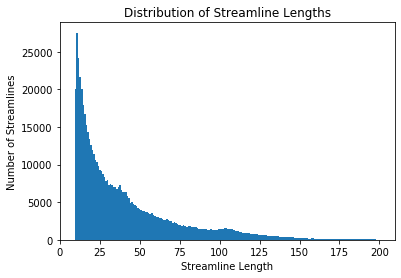

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(lengths, bins=200)

plt.xlabel('Streamline Length')
plt.ylabel('Number of Streamlines')
plt.title('Distribution of Streamline Lengths')

DISCUSS RELEVANCE OF STREAMLNIE DISTRIBUTION

In [45]:
ref_nifti=nib.load('/Users/plab/Documents/JupyerData/proj-5c50b6f12daf2e0032f880eb/sub-100206/dt-neuro-parcellation-volume.id-5c50c3f7ecd2f200ccfe9fae/parc.nii.gz')

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider

niftiData=ref_nifti.get_data()
niftiDataInt=niftiData.astype(np.uint16)

lengthsArray=np.array(lengths)

from dipy.tracking import utils


M, grouping = utils.connectivity_matrix(streamlines=streamsObjIN.tractogram.streamlines, 
                                        affine=ref_nifti.affine, 
                                        label_volume=niftiDataInt.astype(np.int16),
                                        return_mapping=True,
                                        mapping_as_streamlines=False)

uniqueKeys=np.unique(np.ndarray.flatten(niftiDataInt))


import itertools
keyList=list(itertools.combinations(range(roiTotal), 2))

roiTotal=np.max(uniqueKeys)+1

countMatrix=np.zeros([roiTotal,roiTotal])

import itertools
keyList=list(itertools.combinations(range(roiTotal), 2))

countList=[0]*len(keyList)

for iKeys in range(len(keyList)):
    curIndexes=np.asarray(grouping[keyList[iKeys]])
    countList[iKeys]=np.sort(lengthsArray[curIndexes.astype(int)])
    
lowerBound = 0
upperBound = 100
    
def draw_adaptiveMatrix():    
    global keyList
    global countList
    global lowerBound
    global upperBound
    for iKeys in range(len(keyList)): 
        curIndex=keyList[iKeys]
        countMatrix[curIndex] =((lowerBound < countList[iKeys]) & (countList[iKeys] < upperBound)).sum()    
        countMatrix[curIndex[::-1]] =((lowerBound < countList[iKeys]) & (countList[iKeys] < upperBound)).sum()    
    
    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(np.log1p(countMatrix), interpolation='nearest')
    plt.xlabel('Atlas ROI number')
    plt.ylabel('Atlas ROI number')
    
    fig = plt.gcf()
    #fig.colorbar(np.log1p(countMatrix))
    fig.set_size_inches(18.5, 10.5)
    
    plt.subplot(1, 2, 2)
    plt.hist(lengths, bins=200)
    xposition = [lowerBound,upperBound]
    for xc in xposition:
        plt.axvline(x=xc, color='r', linestyle='--', linewidth=3)
    plt.xlabel('Streamline Length')
    plt.ylabel('Number of Streamlines')
    plt.title('Distribution of Streamline Lengths')
    
    return


def update_bound(minimum, maximum):
    global upperBound
    global lowerBound
    lowerBound = minimum
    upperBound = maximum
    draw_adaptiveMatrix()

print("now running")    
minslide=FloatSlider(min=np.min(lengthsArray), max=np.max(lengthsArray), step=1,continuous_update=False)
maxslide=FloatSlider(min=np.min(lengthsArray), max=np.max(lengthsArray), step=1,continuous_update=False)
interact(update_bound, minimum=minslide, maximum=maxslide)
#interact(update_upperbound, maximum=maxslide)
#draw_adaptiveMatrix()

#interact(adaptiveMatrix,{'lowerBound':FloatSlider(min=np.min(lengthsArray), max=np.max(lengthsArray), step=1, continuous_update=False),'upperBound':FloatSlider(min=np.min(lengthsArray), max=np.max(lengthsArray), step=1, continuous_update=False)})

now running


interactive(children=(FloatSlider(value=9.502349853515625, continuous_update=False, description='minimum', max…

<function __main__.update_bound(minimum, maximum)>

DISCUSS HOW VARYING LENGTHS AND PROPERTIES OF THE STREAMLINES CORRESPOND TO SEPARATE ANATOMICAL FEATURES OF THE BRAIN